# Imports

In [1]:
import numpy as np
import os
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from keras.models import save_model,load_model
from keras import layers
from  matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Activation, Dropout,Conv2D,MaxPooling2D

%matplotlib inline

# Drive mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data loading 

Extracting dataset (zip file) into google colab.

In [3]:
from zipfile import ZipFile
%cd '/content'
with ZipFile('/content/drive/MyDrive/ML_project/DIBaS_sliced2.zip','r') as zip:
  zip.extractall()

/content


Converting the images in the dataset to numpy array. 
x - images as numpy array
y - images labels 
labels - python dictionary - {labels:class...}
The labels are 0-11 integers matching the classes. 



In [4]:
data_dir = "/content/DIBaS_sliced"
classes = ['Acinetobacter.baumanii','Actinomyces','Bacteroides','Candida','Clostridium','Enterococcus','Escherichia','Listeria','Neisseria','Proteus','Pseudomonas','Staphylococcus']
labels = {}
y = []
x = []
i=0
for c in classes:
  path = os.path.join(data_dir,c)
  for dir in os.listdir(path):
    if(dir!='.DS_Store'):
      y.append(i)
      img = Image.open(os.path.join(path,dir))
      x.append(np.asarray(img))
  labels[i] = c
  i+=1
x = np.asarray(x)
y = np.asarray(y)

Spliting x and y into train(70%) data and test(30%) data.
Using sklearn.model_selection.train_test_split function.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,train_size=0.7)

Plot a sample of 10 randomly selected images from train dataset

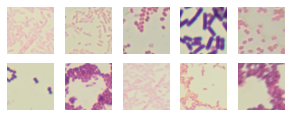

[ 2  2  8  4  8 11  7  2 10  7]


In [6]:
indexes = np.random.randint(0, x_train.shape[0], size=10)
images = x_train[indexes]
lables = y_train[indexes]

# plot 10 images
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
plt.show()
plt.close('all')

print(lables)

# Data Preparation  

In [6]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

# Transfer learning - resnet50

Loading frozen resnet50 model from keras without the final layers 

In [8]:
resnet_model = keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))

94781440/94765736 [==============================] - 1s 0us/step


In [9]:
resnet_model.trainable=False

Final layers to fit our classification

In [10]:
model = keras.models.Sequential()
model.add(resnet_model)
model.add(Conv2D(32,(3,3),activation='relu',kernel_initializer='he_uniform',input_shape=(224,224,3)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(Dropout(0.4))
model.add(layers.BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(12, activation='softmax'))

Early stopping callback. stops the training if there's no improve while saving best weights.

In [11]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=20,restore_best_weights=True)

Model training

In [12]:
batch_size = 32
epochs = 50

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,validation_data = (x_test, y_test),callbacks=early_stopping)

Epoch 1/50
285/285 [==============================] - 109s 320ms/step - loss: 1.1411 - accuracy: 0.6173 - val_loss: 0.5706 - val_accuracy: 0.8021
Epoch 2/50
285/285 [==============================] - 86s 304ms/step - loss: 0.5310 - accuracy: 0.8154 - val_loss: 0.3930 - val_accuracy: 0.8614
Epoch 3/50
285/285 [==============================] - 86s 303ms/step - loss: 0.4296 - accuracy: 0.8505 - val_loss: 0.3840 - val_accuracy: 0.8609
Epoch 4/50
285/285 [==============================] - 86s 303ms/step - loss: 0.3932 - accuracy: 0.8635 - val_loss: 0.3108 - val_accuracy: 0.8950
Epoch 5/50
285/285 [==============================] - 86s 303ms/step - loss: 0.3352 - accuracy: 0.8827 - val_loss: 0.3536 - val_accuracy: 0.8696
Epoch 6/50
285/285 [==============================] - 86s 302ms/step - loss: 0.3002 - accuracy: 0.8947 - val_loss: 0.3071 - val_accuracy: 0.8907
Epoch 7/50
285/285 [==============================] - 86s 303ms/step - loss: 0.2663 - accuracy: 0.9079 - val_loss: 0.2494 - val_a

# Model Evaluation

In [14]:
score = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 90.84%


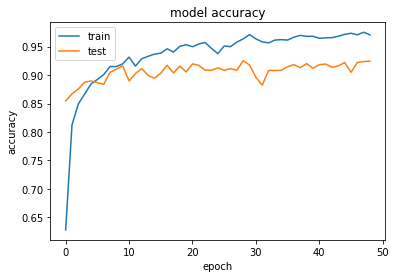

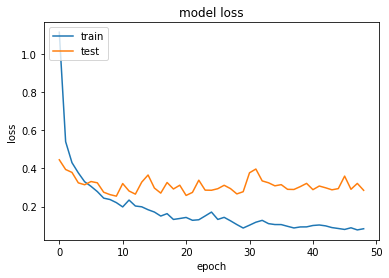

In [13]:
#accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Converting to tf lite model

In [22]:
model.save("MC")


INFO:tensorflow:Assets written to: MC/assets


In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpmgxlps2h/assets


INFO:tensorflow:Assets written to: /tmp/tmpmgxlps2h/assets


In [27]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"
model_name = TF_LITE_MODEL_FILE_NAME
open(model_name,"wb").write(tfmodel)


96348644